# Learning XOR on an Optical network with unidirectional transmission

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Dataset 
inputs = np.array([-1, 1])
targets = np.array([-0.1, 0.1])
#targets = np.array([0.1, -0.1]) # (easier to learn)

# Parameters
np.random.seed(11) # seed
N = 2 # Number of nodes
kappa = np.array([0.8, 1.3])  # Decay rates
g = 0.1  # Nonlinearity
J = np.random.randn(N, N)  # Connectivity matrix
J = (J + J.T) / 2
beta = 1e-2  # Perturbation magnitude
Omega = np.diag(np.random.rand(N)) 

# Initialize state
y0 = np.random.randn(2*N) + 1j * np.random.randn(2*N)
a_in = np.random.randn(N) + 1j * np.random.randn(N)
b_in = np.random.randn(N) + 1j * np.random.randn(N)

# System dynamics
def system(t, y, args):
    
    kappa, g, Omega, a_in, b_in = args
    N = len(kappa)
    # Split the input state vector
    a = y[:N]
    b = y[N:]

    # Compute nonlinear terms
    a_nl = -1j * 2 * g * (np.abs(a)**2 + 2 * np.abs(b)**2) * a
    b_nl = -1j * 2 * g * (np.abs(b)**2 + 2 * np.abs(a)**2) * b

    m1 = np.array([[0.5, 0.], [1., 0.5]])

    # Compute detuning and decay
    a_linear = - kappa * m1 @ a - 1j * Omega @ a
    b_linear = - kappa * (m1.T) @ b - 1j * Omega @ b

    m2 = np.array([[1., 0.], [1., 0.]])
    m3 = np.array([[0., 1.], [0., 1.]])
    
    # Input driving
    a_drive = -np.sqrt(kappa) * m2 @ a_in
    b_drive = -np.sqrt(kappa) * m3 @ b_in

    # Total derivatives
    da_dt = a_linear + a_nl + a_drive
    db_dt = b_linear + b_nl + b_drive

    return np.concatenate([da_dt, db_dt])

t_span = (0, 30)
dt = 0.01

In [ ]:
# Runge Kutta Ode solver

def rk4_step(f, y, t, dt, args):
    """Performs a single step of the 4th-order Runge-Kutta method for solving ODEs."""
    k1 = f(t, y, args)
    k2 = f(t + 0.5 * dt, y + 0.5 * dt * k1 * dt, args)
    k3 = f(t + 0.5 * dt, y + 0.5 * dt * k2 * dt, args)
    k4 = f(t + dt, y + k3 * dt, args)
    
    return y + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

def solve_rk4(f, y0, t_span, dt, args):
    """Solves an ODE using RK4 over a time range."""
    t_values = np.arange(t_span[0], t_span[1] + dt, dt)
    y_values = []
    y_values.append(y0)
    
    for i in range(1, len(t_values)):
        y_values.append(rk4_step(f, y_values[i-1], t_values[i-1], dt, args))
    
    return t_values, np.array(y_values)

# Training

In [4]:
loss_history = [] # Loss history

# Training loop
num_epochs = 100
# Learning rate
learning_rate = 0.1

for epoch in range(num_epochs):  # Number of epochs
    epoch_loss = 0
    for input, target in zip(inputs, targets):
        # Set inputs
        a_in = np.zeros(N) + 1j * np.zeros(N)
        b_in = np.zeros(N) + 1j * np.zeros(N)
        a_out = np.zeros(N) + 1j * np.zeros(N)
        b_out = np.zeros(N) + 1j * np.zeros(N)

        a_in[0] = input + 1j * 0.
        a_in[1] = a_in[0]

        # Inference Phase
        _, steady_state = solve_rk4(system, y0, t_span, dt, args=(kappa, g, Omega, a_in, b_in))
        a_bar, b_bar = steady_state[-1,:N], steady_state[-1, N:]
        
        
        a_out[0] = a_in[0] + (kappa[0])**0.5 * a_bar[0]
        a_in[1] = a_out[0]
        a_out[1] = a_in[1] +  (kappa[1])**0.5 * a_bar[1]

        b_out[1] = b_in[1] + (kappa[1])**0.5 * b_bar[1]
        b_in[0] = b_out[1]
        b_out[0] = b_in[0] + (kappa[0])**0.5 * b_bar[0]
        

        y = a_out[1].real #network output

        # Compute loss for the current sample
        loss = (y - target)**2    
        epoch_loss += loss

        # Feedback Phase:
        # Error signal
        delta_b_in = np.zeros(N) + 1j * np.zeros(N)
        delta_b_in[1] =  beta * (y - target)

        a_pert_in = a_in 
        b_pert_in = b_in + delta_b_in

        a_pert_out = np.zeros(N) + 1j * np.zeros(N)
        b_pert_out = np.zeros(N) + 1j * np.zeros(N)
        
        _, perturbed_steady_state = solve_rk4(system, y0, t_span, dt, args=(kappa, g, Omega, a_pert_in, b_pert_in))
        a_pert_bar, b_pert_bar = perturbed_steady_state[-1][:N], perturbed_steady_state[-1][N:]

        a_pert_out[0] = a_pert_in[0] + (kappa[0])**0.5 * a_pert_bar[0]
        a_pert_in[1] = a_pert_out[0]
        a_pert_out[1] = a_pert_in[1] + (kappa[1])**0.5 * a_pert_bar[1]
        
        b_pert_out[1] = b_pert_in[1] + (kappa[1])**0.5 * b_pert_bar[1]
        b_pert_in[0] = b_pert_out[1]
        b_pert_out[0] = b_pert_in[0] + (kappa[0])**0.5 * b_pert_bar[0]
        

        xi_in = np.concatenate([a_in, b_in])
        xi_out = np.concatenate([a_out, b_out])
        xi_pert_in = np.concatenate([a_pert_in, b_pert_in])
        xi_pert_out = np.concatenate([a_pert_out, b_pert_out])
        delta_xi_in = xi_pert_in - xi_in
        delta_xi_out = xi_pert_out - xi_out

        # Update weights
        for j in range(N):
            dOmega_j = - 2/(beta*kappa[j]) * ( 
                (xi_out[j+N] - xi_in[j+N])*(delta_xi_out[j]-delta_xi_in[j])+
                (xi_out[j] - xi_in[j])*(delta_xi_out[j+N]-delta_xi_in[j+N])-
                (xi_out[j] - xi_in[j])*(delta_xi_out[(j+1)%2+N]-delta_xi_in[(j+1)%2+N])
            ).imag 
            Omega[j,j] -= learning_rate * dOmega_j

    # Average loss for the epoch
    epoch_loss = epoch_loss / len(inputs)
    loss_history.append(epoch_loss)


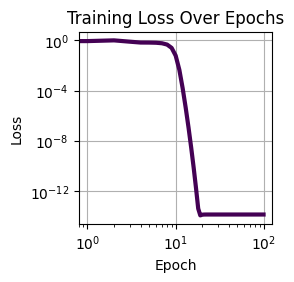

In [10]:
# Plot the loss graph
colors = plt.cm.viridis(np.linspace(0, 1, 3))

plt.figure(figsize=(2.5, 2.5))
plt.plot(loss_history[:], label='Loss', color = colors[0], linewidth = 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.yscale('log')
plt.yticks([1e-0, 1e-4, 1e-8, 1e-12])
plt.xscale('log')
plt.show()

# Evaluation

F(-1) = -0.09999573940513695
Target = -0.1


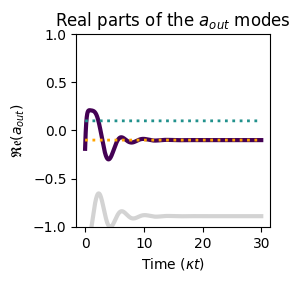

F(1) = 0.09998874912816358
Target = 0.1


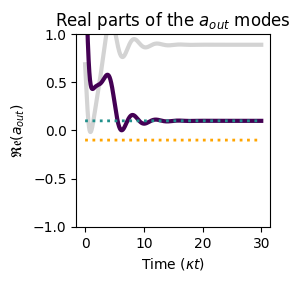

In [11]:
import os
np.random.seed(32) # seed
y0 = np.random.randn(2*N) + 1j * np.random.randn(2*N)

# Evaluation loop
num_epochs = 1
        

for epoch in range(num_epochs):  # Number of epochs
    epoch_loss = 0
    for input, target in zip(inputs, targets):
        # Set inputs
        a_in = np.zeros(N) + 1j * np.zeros(N)
        b_in = np.zeros(N) + 1j * np.zeros(N)
        a_in[0] = input + 1j * 0.
        a_in[1] = a_in[0]
        
        # Inference phase
        t_vals, steady_state = solve_rk4(system, y0, t_span, dt, args=(kappa, g, Omega, a_in, b_in))
        a_bar, b_bar = steady_state[-1,:N], steady_state[-1, N:]

        a_out[0] = a_in[0] + kappa[0]**0.5 * a_bar[0]
        a_in[1] = a_out[0]
        a_out[1] = a_in[1] + kappa[1]**0.5 * a_bar[1]
        
        y = a_out[1].real
        

        plt.figure(figsize=(2.5, 2.5))
        plt.plot(t_vals, input + kappa[0]**0.5 * steady_state[:,0].real, color='lightgray', linewidth = 3)  #a_out,1
        plt.plot(t_vals, input + kappa[0]**0.5 * steady_state[:,0].real + kappa[1]**0.5 * steady_state[:,1].real, color=colors[0], linewidth = 3)  #a_out,2
        plt.plot(t_vals, 0.1*np.ones(len(t_vals)), color=colors[1], linestyle = 'dotted', linewidth = 2)
        plt.plot(t_vals, -0.1*np.ones(len(t_vals)), color='orange', linestyle = 'dotted', linewidth = 2)
        plt.xlabel(r'Time ($\kappa t$)')
        plt.ylabel(r'$\mathfrak{Re}(a_{out})$')
        plt.ylim((-1., 1.))
        plt.title(r'Real parts of the $a_{out}$ modes')
        print(f"F({input}) = {y}")
        print(f"Target = {target}")
        plt.show()
